# Extração de Características

EDIT: Estou avaliando com matriz de coocorrencia porque com fft não discriminou bem


In [2]:
# ref: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut, cat, microaneurysms, rocket, horse, retina, coins
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
import networkx as nx


from egsis.complex_networks import complex_network_from_segments
from egsis.complex_networks import draw_complex_network
from egsis.superpixels import build_superpixels_from_image
from egsis.superpixels import superpixel_centroids
from egsis.superpixels import superpixels_max_radius
from egsis import features

# Gerar Superpixels

(-0.5, 450.5, 299.5, -0.5)

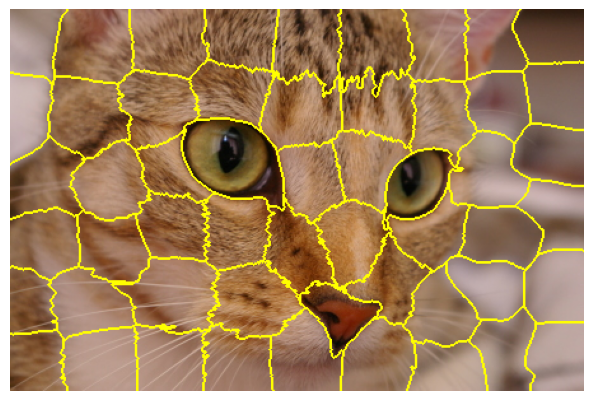

In [6]:
img = img_as_ubyte(cat())
superpixels = build_superpixels_from_image(img, n_segments=50, compactness=40)
ax = plt.imshow(mark_boundaries(img, superpixels))
plt.tight_layout()
plt.axis('off')

# Gerar Rede Complexa

(-36.045, 483.04499999999996, 320.4, -18.4)

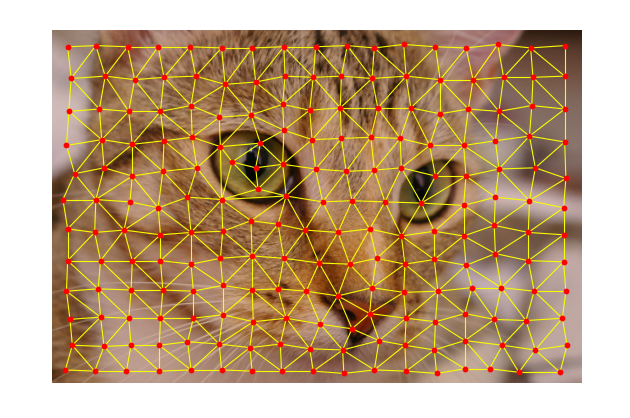

In [4]:
complex_network = complex_network_from_segments(superpixels)
centroids = superpixel_centroids(superpixels)
plt.imshow(img)
draw_complex_network(complex_network, superpixels)
plt.tight_layout()
plt.axis('off')

In [4]:
complex_network.degree[21]

5

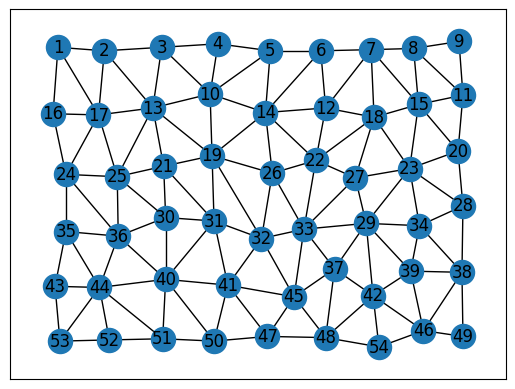

In [5]:
nx.draw_networkx(complex_network, pos=superpixel_centroids(superpixels))
plt.gca().invert_yaxis()
plt.show()

Max superpixel radius: 40


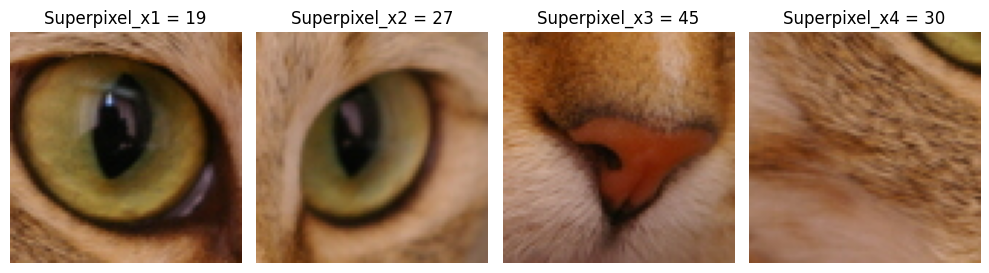

In [6]:
max_radius = superpixels_max_radius(superpixels, centroids)
print(f"Max superpixel radius: {max_radius}")
def plot_superpixel(ax, superpixel, idx):
    segment = features.get_segment_by_label_cropped(
        img,
        superpixels,
        superpixel,
        max_radius=max_radius,
        centroid=centroids[superpixel],
        erase_color=None
    )
    ax.set_title(f"Superpixel_x{idx+1} = {superpixel}")
    ax.imshow(segment)
    
selected_superpixels = [19, 27, 45, 30]


fig, ax = plt.subplots(1, len(selected_superpixels), figsize=(10, 10), sharex=True, sharey=True)
for idx, superpixel in enumerate(selected_superpixels):    
    plot_superpixel(ax[idx], superpixel, idx)



for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Avaliação de características por matriz de similaridade

## FFT

FFT não teve obteve resultados tão bons

## Matriz de co-ocorrência + similaridade euclidiana

Testei FFT e matriz de co-ocorrência, a matriz de co-ocorrência obteve um melhor resultado em comparação a fft multidimensional. Fiz a matriz de co-ocorrência individual para cada canal obtendo métricas de correlação, dissimilaridade energia e alternância do sinal da matriz. A distância utilizada foi 10 em relação aos ângulos 0, 90, 180 e 270 graus. Para cada métrica calculei a media, mediana, variância, desvio padrão e quantil de 25.

In [7]:
# Build similarity matrix
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray

img_segments = [
    features.get_segment_by_label_cropped(
        img, 
        superpixels, 
        selected_superpixels[i],
        max_radius=max_radius,
        centroid=centroids[selected_superpixels[i]],
        erase_color=None
    )
    for i in range(len(selected_superpixels))
]
vectors = [features.feature_extraction_comatrix(x) for x in img_segments]
# vectors = img_segments
n_vectors = len(vectors)
similarity_matrix = np.zeros(shape=(n_vectors, n_vectors))
similarity_matrix 

for i in range(n_vectors):
    for j in range(n_vectors):
        if i == j:
            continue
        similarity_matrix[i, j] = features.euclidian_similarity(vectors[i], vectors[j])

        
similarity_matrix = np.around(similarity_matrix, decimals=10)
similarity_matrix

array([[0.        , 0.0427309 , 0.0232987 , 0.01595672],
       [0.0427309 , 0.        , 0.0299112 , 0.02026514],
       [0.0232987 , 0.0299112 , 0.        , 0.04248002],
       [0.01595672, 0.02026514, 0.04248002, 0.        ]])

In [8]:
vectors[0]

array([ 2.97988104e-01,  2.79770788e-01,  6.99712270e-03,  8.36488057e-02,
        2.27699945e-01,  1.16341185e-02,  1.15893112e-02,  9.19735168e-09,
        9.59028242e-05,  1.15686959e-02,  1.35361910e-04,  1.34312452e-04,
        5.02263696e-12,  2.24112404e-06,  1.33834749e-04,  4.76339188e+01,
        4.78694035e+01,  7.53034405e+00,  2.74414724e+00,  4.61000427e+01,
        2.33427845e-01,  2.15930062e-01,  7.04349159e-03,  8.39255122e-02,
        1.61227436e-01,  1.26422622e-02,  1.26059971e-02,  4.27064833e-08,
        2.06655470e-04,  1.24513497e-02,  1.59869501e-04,  1.58933115e-04,
        2.74101092e-11,  5.23546647e-06,  1.55036235e-04,  4.04435684e+01,
        4.06583040e+01,  5.44978663e+00,  2.33447781e+00,  3.90120989e+01,
        1.61098883e-01,  1.42352126e-01,  2.93957411e-02,  1.71451862e-01,
       -1.61246006e-03,  1.49499959e-02,  1.47904696e-02,  9.18694273e-08,
        3.03099699e-04,  1.47672824e-02,  2.23594247e-04,  2.18758242e-04,
        8.40369512e-11,  

Text(0.5, 1.0, 'Similarity Matrix over feature space')

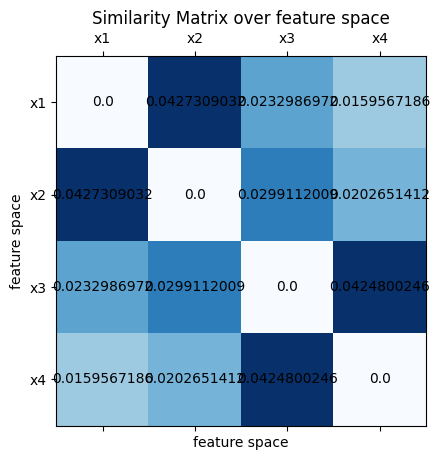

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.matshow(similarity_matrix, cmap=plt.cm.Blues)

for i in range(n_vectors):
    for j in range(n_vectors):
        c = similarity_matrix[i, j]
        ax.text(i, j, str(c), va='center', ha='center')
        
axis_labels =[f"x{k+1}" for k in range(len(selected_superpixels))]
axis_range = range(len(axis_labels))
plt.xticks(axis_range, axis_labels)
plt.yticks(axis_range, axis_labels)
plt.xlabel("feature space")
plt.ylabel("feature space")
plt.title("Similarity Matrix over feature space")

# Interpretação

Essa métrica tornou-se interessante pois x1 vs x2 e x3 vs x4 visualmente são os segmentos mais semelhantes entre si